<a href="https://colab.research.google.com/github/marcelounb/tensorflow_udacity/blob/master/03_dogs_vs_cats_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import math
from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import Dropout 
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.optimizers import SGD

# Imports for the CNN
from keras.layers import Flatten 
from keras.layers.convolutional import Convolution2D 
from keras.layers.convolutional import MaxPooling2D
from keras import backend as K 
from random import randrange

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68608000/68606236 [==============================] - 1s 0us/step


In [4]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train/cats


In [5]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [6]:
base_dir, train_dir, validation_dir, train_cats_dir, train_dogs_dir, validation_cats_dir, validation_dogs_dir

('/root/.keras/datasets/cats_and_dogs_filtered',
 '/root/.keras/datasets/cats_and_dogs_filtered/train',
 '/root/.keras/datasets/cats_and_dogs_filtered/validation',
 '/root/.keras/datasets/cats_and_dogs_filtered/train/cats',
 '/root/.keras/datasets/cats_and_dogs_filtered/train/dogs',
 '/root/.keras/datasets/cats_and_dogs_filtered/validation/cats',
 '/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs')

In [7]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [8]:
num_cats_tr, num_dogs_tr, num_cats_val, num_dogs_val ,total_train, total_val

(1000, 1000, 500, 500, 2000, 1000)

In [9]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


# Setting Model Parameters
For convenience, we'll set up variables that will be used later while pre-processing our dataset and training our network.

In [10]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

# Data Preparation
Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:

1. Read images from the disk
2. Decode contents of these images and convert it into proper grid format as per their RGB content
3. Convert them into floating point tensors
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done using the class tf.keras.preprocessing.image.ImageDataGenerator.

We can set this up in a couple of lines of code

In [11]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

After defining our generators for training and validation images, flow_from_directory method will load images from the disk, apply rescaling, and resize them using single line of code.

In [12]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [13]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


# Visualizing Training images
We can visualize our training images by getting a batch of images from the training generator, and then plotting a few of them using matplotlib.

In [14]:
sample_training_images, _ = next(train_data_gen)

The next function returns a batch from the dataset. One batch is a tuple of (many images, many labels). For right now, we're discarding the labels because we just want to look at the images.

In [15]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

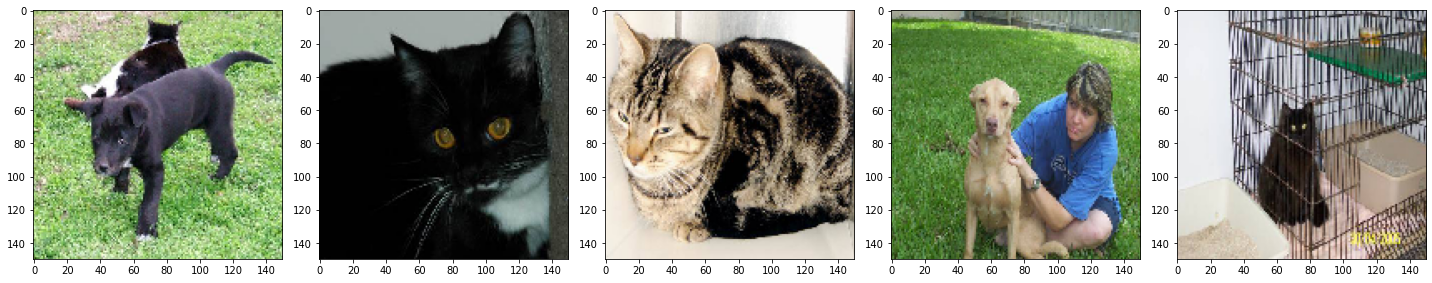

In [16]:
plotImages(sample_training_images[:5])  # Plot images 0-4

# Model Creation

In [17]:
def cnn_model_my_way():
  # create model 
  model = Sequential() 
  model.add(Convolution2D(32, (3, 3), input_shape=(150, 150, 3), activation= 'relu' )) 
  model.add(MaxPooling2D((2, 2)))

  model.add(Convolution2D(64, (3, 3), activation= 'relu' )) 
  model.add(MaxPooling2D((2, 2)))

  model.add(Convolution2D(128, (3, 3), activation= 'relu' )) 
  model.add(MaxPooling2D((2, 2)))

  model.add(Convolution2D(128, (3, 3), activation= 'relu' )) 
  model.add(MaxPooling2D((2, 2)))
  
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(2))

  # Compile model 
  model.compile(loss= 'sparse_categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ]) 
  return model

In [18]:
model = cnn_model_my_way()

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [24]:
EPOCHS = 35
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/35
20/20 [==============================] - 85s 4s/step - loss: 0.6733 - accuracy: 0.5860 - val_loss: 0.6577 - val_accuracy: 0.6140
Epoch 2/35
20/20 [==============================] - 85s 4s/step - loss: 0.6240 - accuracy: 0.6450 - val_loss: 0.6181 - val_accuracy: 0.6610
Epoch 3/35
20/20 [==============================] - 85s 4s/step - loss: 0.5789 - accuracy: 0.7000 - val_loss: 0.6069 - val_accuracy: 0.6580
Epoch 4/35
20/20 [==============================] - 87s 4s/step - loss: 0.5446 - accuracy: 0.7325 - val_loss: 0.5942 - val_accuracy: 0.6750
Epoch 5/35
20/20 [==============================] - 85s 4s/step - loss: 0.5040 - accuracy: 0.7590 - val_loss: 0.5845 - val_accuracy: 0.6970
Epoch 6/35
20/20 [==============================] - 86s 4s/step - loss: 0.4572 - accuracy: 0.7810 - val_loss: 0.5572 - val_accuracy: 0.7260
Epoch 7/35
20/20 [==============================] - 86s 4s/step - loss: 0.3971 - accuracy: 0.8205 - val_loss: 0.5971 - val_accuracy: 0.7210
Epoch 8/35
20/20 [==

# Visualizing results of the training

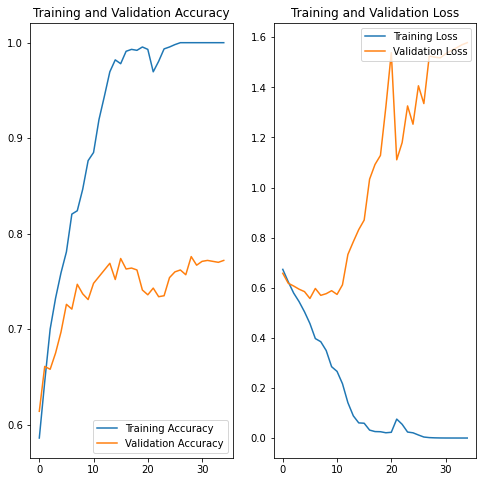

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()